In [1]:
# Standard python helper libraries.
import os, sys, re, json, time, wget, csv, string, time, random
import itertools, collections

# NumPy
import numpy as np

# NLTK for NLP utils
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from keras import backend as K
from keras.models import Sequential
from keras.layers import GaussianNoise, Dropout, Dense, Embedding, MaxPool1D, GlobalMaxPool1D, Conv1D
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from pymagnitude import *

[nltk_data] Downloading package punkt to /home/renzeer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renzeer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Binary Classifier for Cardiovascular Disease using a Convolutional Neural Network

In this notebook, we will be building a model for classifying a sentence from an EHR note for the presence of cardiovascular disease. The model will be trained using a convoultional neural network (CNN). 

## Text Preprocessing

In [2]:
ehr_notes = []
with open('data/ehr_samples.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:     
        if int(row['SpecialtyID']) in [39, 6, 16, 37, 11, 12, 29, 26, 7, 21, 19, 10, 2, 18]:
            continue
        elif int(row['SpecialtyID']) != 4:
            ehr_notes.append(['Other', row['Note']])
        else:
            ehr_notes.append([row['Specialty'], row['Note']])

print(ehr_notes[0])
print(ehr_notes[2])

['Other', 'PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two blocks or five flights of stairs.  Difficulty with snoring.  He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling.  He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago.  ,SOCIAL HISTORY:, He is currently single.  He has about ten drinks a year.  He had smoked significantly up until several months ago.  He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes.  Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:,  He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:

## Natural Langauge Processing

In [3]:
ehr_sentences = []
for record in ehr_notes:
    sent_text = nltk.sent_tokenize(record[1])
    for sent in sent_text:
        tokens = word_tokenize(sent)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]

#         # stem words
#         porter = PorterStemmer()
#         tokens = [porter.stem(word) for word in tokens]

        # remove blanks
        tokens = [w for w in tokens if w != '']

        ehr_sentences.append([record[0], ' '.join(tokens)])

random.Random(4).shuffle(ehr_sentences)

print(ehr_sentences[0])
print(ehr_sentences[1])

['Cardiovascular', 'return clinic 4 weeks5']
['Other', 'biceps tendon nonsubluxable']


## Word Embedding

The first step is to load in our word embedding, which is trained on text from Wikipedia, Pubmed, and Pubmed Central. We load our word embedding through a tool called Magnitude. A full exploration of the word embedding and Magnitude can be found in the Introduction notebook.

In [4]:
med_vectors = Magnitude("data/wikipedia-pubmed-and-PMC-w2v.magnitude", pad_to_length=30)

## Defining our Training and Test Data

Before we can start building our neural networks, we first have to define our datasets. Specifically, we have to break up our EHR data so that we have records that we can train on and records that are exclusively used to test on. Maintaining a separate set for testing ensures we avoid overfitting our data.

We will use some built-in functions provided by Magnitude that helps encode our classes/categories. We then partition our data into our train and test sets. For each set we have both data and labels. Initially, we will be making these partitions small to make iterating through model development much quicker. However, once the models are developed, we will expand our datasets to include all of our data. To ensure we defined our data correctly, we can print a few lines from the two sets.

In [5]:
len(ehr_sentences)

70941

In [6]:
add_intent, intent_to_int, int_to_intent = MagnitudeUtils.class_encoding()

x_train = [ehr_sent[1].split(' ') for ehr_sent in ehr_sentences[:60000]]
x_test = [ehr_sent[1].split(' ') for ehr_sent in ehr_sentences[60001:]]

y_train = [add_intent(ehr_sent[0]) for ehr_sent in ehr_sentences[:60000]]
y_test = [add_intent(ehr_sent[0]) for ehr_sent in ehr_sentences[60001:]]

y_train = list(np.array(y_train).reshape(len(y_train)))
y_test = list(np.array(y_test).reshape(len(y_test)))

num_training = len(x_train)
num_test = len(x_test)
num_outputs = int(max(max(y_train), max(y_test))) + 1

print(int_to_intent(0))

print("First line of train/test data:")
print("\t", x_train[0])
print("\t", y_train[0], int_to_intent(y_train[0]))
print("\t", x_test[0])
print("\t", y_test[0], int_to_intent(y_test[0]))
print("Second line of train/test data:")
print("\t", x_train[1])
print("\t", y_train[1], int_to_intent(y_train[1]))
print("\t", x_test[1])
print("\t", y_test[1], int_to_intent(y_test[1]))

Cardiovascular
First line of train/test data:
	 ['return', 'clinic', '4', 'weeks5']
	 0 Cardiovascular
	 ['smokes', 'one', 'pack', 'per', 'day']
	 0 Cardiovascular
Second line of train/test data:
	 ['biceps', 'tendon', 'nonsubluxable']
	 1 Other
	 ['denies', 'illicit', 'drug', 'use', 'family', 'history', 'parents', 'died', 'myocardial', 'infarctions']
	 1 Other


## Defining Custom Callback Function

In [7]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Defining Model

In [8]:
MAX_WORDS = 30 # The maximum number of words the sequence model will consider
STD_DEV = 0.01 # Deviation of noise for Gaussian Noise applied to the embeddings
DROPOUT_RATIO = .5 # The ratio to dropout
BATCH_SIZE = 100 # The number of examples per train/validation step
EPOCHS = 100 # The number of times to repeat through all of the training data
LEARNING_RATE = .01 # The learning rate for the optimizer
NUM_FILTERS = 128

model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, med_vectors.dim)))
model.add(Conv1D(NUM_FILTERS, 7, activation='relu', padding='same'))
model.add(MaxPool1D(2))
model.add(Conv1D(NUM_FILTERS, 7, activation='relu', padding='same'))
model.add(GlobalMaxPool1D())
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 30, 200)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           179328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

## Training Batches and Epochs

In [9]:
training_batches = MagnitudeUtils.batchify(x_train, y_train, BATCH_SIZE) # Split the training data into batches
num_batches_per_epoch_train = int(np.ceil(num_training/float(BATCH_SIZE)))
test_batches = MagnitudeUtils.batchify(x_test, y_test, BATCH_SIZE)  # Split the test data into batches
num_batches_per_epoch_test = int(np.ceil(num_test/float(BATCH_SIZE)))


# Generates batches of the transformed training data
train_batch_generator = (
  (
    med_vectors.query(x_train_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_train_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_train_batch, y_train_batch in training_batches
)

# Generates batches of the transformed test data
test_batch_generator = (
  (
    med_vectors.query(x_test_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_test_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_test_batch, y_test_batch in test_batches
)

# Class weights
class_weight = {
    intent_to_int('Cardiovascular'): 6.
    ,intent_to_int('Other'): 1.
}

# Start training
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = test_batch_generator,
    validation_steps = num_batches_per_epoch_test,
    epochs = EPOCHS,
    class_weight=class_weight
)

Epoch 1/100
600/600 [==============================] - 330s 550ms/step - loss: 0.8886 - acc: 0.7521 - f1: 0.7521 - val_loss: 0.5790 - val_acc: 0.7010 - val_f1: 0.7010
Epoch 2/100
600/600 [==============================] - 17s 28ms/step - loss: 0.7526 - acc: 0.7997 - f1: 0.7997 - val_loss: 0.5020 - val_acc: 0.7478 - val_f1: 0.7478
Epoch 3/100
600/600 [==============================] - 19s 31ms/step - loss: 0.6239 - acc: 0.8305 - f1: 0.8305 - val_loss: 0.4607 - val_acc: 0.7653 - val_f1: 0.7653
Epoch 4/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3676 - acc: 0.8941 - f1: 0.8941 - val_loss: 0.4848 - val_acc: 0.7978 - val_f1: 0.7978
Epoch 8/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3378 - acc: 0.9028 - f1: 0.9028 - val_loss: 0.4730 - val_acc: 0.8237 - val_f1: 0.8237
Epoch 9/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3143 - acc: 0.9103 - f1: 0.9103 - val_loss: 0.5470 - val_acc: 0.7876 - val_f1: 0.7876
Epoch 10

600/600 [==============================] - 16s 27ms/step - loss: 0.1609 - acc: 0.9495 - f1: 0.9495 - val_loss: 0.7950 - val_acc: 0.8517 - val_f1: 0.8517
Epoch 54/100
600/600 [==============================] - 17s 28ms/step - loss: 0.1546 - acc: 0.9509 - f1: 0.9509 - val_loss: 0.7867 - val_acc: 0.8403 - val_f1: 0.8403
Epoch 55/100
600/600 [==============================] - 16s 27ms/step - loss: 0.1583 - acc: 0.9495 - f1: 0.9495 - val_loss: 0.7605 - val_acc: 0.8420 - val_f1: 0.8420
Epoch 56/100
600/600 [==============================] - 16s 27ms/step - loss: 0.1581 - acc: 0.9499 - f1: 0.9499 - val_loss: 0.7429 - val_acc: 0.8399 - val_f1: 0.8399
Epoch 57/100
600/600 [==============================] - 16s 27ms/step - loss: 0.1616 - acc: 0.9495 - f1: 0.9495 - val_loss: 0.7352 - val_acc: 0.8499 - val_f1: 0.8499
Epoch 58/100
600/600 [==============================] - 16s 27ms/step - loss: 0.1574 - acc: 0.9506 - f1: 0.9506 - val_loss: 0.7890 - val_acc: 0.8452 - val_f1: 0.8452
Epoch 59/100
600/

## Results

In [10]:
print("Results after training for %d epochs:" % (EPOCHS,))

train_metrics = model.evaluate_generator(
    generator = train_batch_generator,
    steps = num_batches_per_epoch_train,
)

print("loss: %.4f - categorical_accuracy: %.4f - f1: %.4f" % tuple(train_metrics))

val_metrics = model.evaluate_generator(
    generator = test_batch_generator,
    steps = num_batches_per_epoch_test,
)

print("val_loss: %.4f - val_categorical_accuracy: %.4f - f1: %.4f" % tuple(val_metrics))

Results after training for 100 epochs:
loss: 0.0963 - categorical_accuracy: 0.9565 - f1: 0.9565
val_loss: 1.0627 - val_categorical_accuracy: 0.8430 - f1: 0.8430


## Conclusion

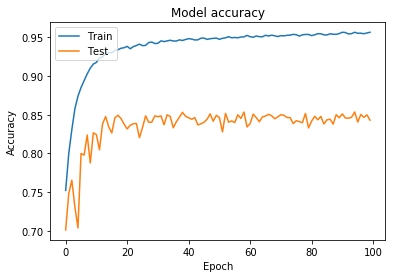

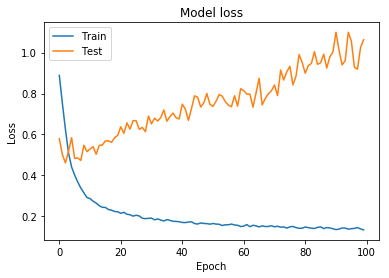

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(med_vectors.query(x_test)), axis=1)
class_labels = [int_to_intent(y) for y in set(y_test)] 
report = classification_report(y_test, y_pred, target_names=class_labels)
print(class_labels)
print(confusion_matrix(y_test, y_pred))
print(report)

['Cardiovascular', 'Other']
[[1049  628]
 [1090 8173]]
                precision    recall  f1-score   support

Cardiovascular       0.49      0.63      0.55      1677
         Other       0.93      0.88      0.90      9263

   avg / total       0.86      0.84      0.85     10940



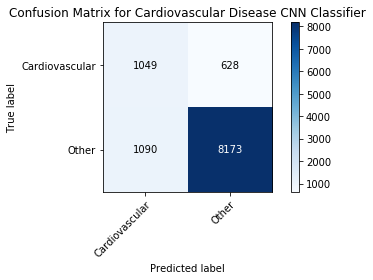

In [13]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [int_to_intent(y_class) for y_class in unique_labels(y_test, y_pred)]

    fig, ax = plt.subplots()
#     fig.set_figheight(15)
#     fig.set_figwidth(15)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_labels
                      , title='Confusion Matrix for Cardiovascular Disease CNN Classifier')

In [15]:
# Class weights
class_weight = {
    intent_to_int('Cardiovascular'): 50.
    ,intent_to_int('Other'): 1.
}

# Start training
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = test_batch_generator,
    validation_steps = num_batches_per_epoch_test,
    epochs = EPOCHS,
    class_weight=class_weight
)

Epoch 1/100
600/600 [==============================] - 17s 29ms/step - loss: 0.4572 - acc: 0.9094 - f1: 0.9094 - val_loss: 0.8794 - val_acc: 0.8184 - val_f1: 0.8184
Epoch 2/100
600/600 [==============================] - 17s 28ms/step - loss: 0.3466 - acc: 0.9247 - f1: 0.9247 - val_loss: 0.9912 - val_acc: 0.7871 - val_f1: 0.7871
Epoch 3/100
600/600 [==============================] - 17s 28ms/step - loss: 0.3384 - acc: 0.9261 - f1: 0.9261 - val_loss: 0.9287 - val_acc: 0.8159 - val_f1: 0.8159
Epoch 4/100
600/600 [==============================] - 17s 28ms/step - loss: 0.3249 - acc: 0.9295 - f1: 0.9295 - val_loss: 1.0012 - val_acc: 0.8031 - val_f1: 0.8031
Epoch 5/100
600/600 [==============================] - 17s 28ms/step - loss: 0.3393 - acc: 0.9267 - f1: 0.9267 - val_loss: 1.0500 - val_acc: 0.7972 - val_f1: 0.7972
Epoch 6/100
600/600 [==============================] - 17s 28ms/step - loss: 0.3301 - acc: 0.9299 - f1: 0.9299 - val_loss: 0.9338 - val_acc: 0.8101 - val_f1: 0.8101
Epoch 7/10

600/600 [==============================] - 23s 38ms/step - loss: 0.3001 - acc: 0.9371 - f1: 0.9371 - val_loss: 0.9644 - val_acc: 0.8010 - val_f1: 0.8010
Epoch 51/100
600/600 [==============================] - 23s 38ms/step - loss: 0.3468 - acc: 0.9307 - f1: 0.9307 - val_loss: 0.8639 - val_acc: 0.8227 - val_f1: 0.8227
Epoch 52/100
600/600 [==============================] - 23s 39ms/step - loss: 0.3255 - acc: 0.9329 - f1: 0.9329 - val_loss: 0.9025 - val_acc: 0.8265 - val_f1: 0.8265
Epoch 53/100
600/600 [==============================] - 23s 38ms/step - loss: 0.3118 - acc: 0.9350 - f1: 0.9350 - val_loss: 0.9467 - val_acc: 0.8273 - val_f1: 0.8273
Epoch 54/100
600/600 [==============================] - 23s 38ms/step - loss: 0.3142 - acc: 0.9354 - f1: 0.9354 - val_loss: 0.9833 - val_acc: 0.8217 - val_f1: 0.8217
Epoch 55/100
600/600 [==============================] - 24s 40ms/step - loss: 0.3033 - acc: 0.9368 - f1: 0.9367 - val_loss: 1.0645 - val_acc: 0.8268 - val_f1: 0.8268
Epoch 56/100
600/

600/600 [==============================] - 23s 38ms/step - loss: 0.3133 - acc: 0.9338 - f1: 0.9338 - val_loss: 0.9799 - val_acc: 0.8160 - val_f1: 0.8160
Epoch 100/100
600/600 [==============================] - 23s 38ms/step - loss: 0.2968 - acc: 0.9374 - f1: 0.9374 - val_loss: 1.0450 - val_acc: 0.8054 - val_f1: 0.8054


In [16]:
print("Results after training for %d epochs:" % (EPOCHS,))

train_metrics = model.evaluate_generator(
    generator = train_batch_generator,
    steps = num_batches_per_epoch_train,
)

print("loss: %.4f - categorical_accuracy: %.4f - f1: %.4f" % tuple(train_metrics))

val_metrics = model.evaluate_generator(
    generator = test_batch_generator,
    steps = num_batches_per_epoch_test,
)

print("val_loss: %.4f - val_categorical_accuracy: %.4f - f1: %.4f" % tuple(val_metrics))

Results after training for 100 epochs:
loss: 0.2376 - categorical_accuracy: 0.9332 - f1: 0.9332
val_loss: 1.0450 - val_categorical_accuracy: 0.8054 - f1: 0.8054


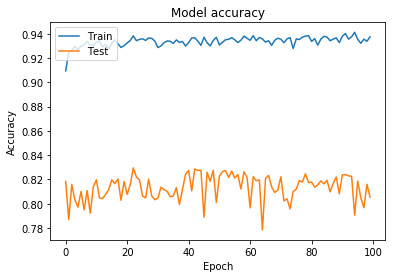

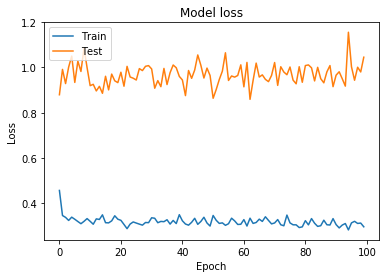

In [17]:
# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
y_pred = np.argmax(model.predict(med_vectors.query(x_test)), axis=1)
class_labels = [int_to_intent(y) for y in set(y_test)] 
report = classification_report(y_test, y_pred, target_names=class_labels)
print(class_labels)
print(confusion_matrix(y_test, y_pred))
print(report)

['Cardiovascular', 'Other']
[[1174  503]
 [1626 7637]]
                precision    recall  f1-score   support

Cardiovascular       0.42      0.70      0.52      1677
         Other       0.94      0.82      0.88      9263

   avg / total       0.86      0.81      0.82     10940



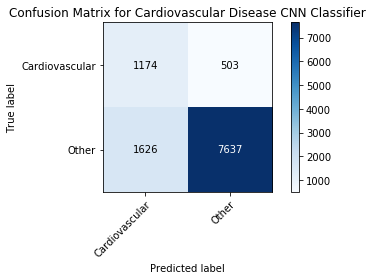

In [19]:
plot_confusion_matrix(y_test, y_pred, classes=class_labels
                      , title='Confusion Matrix for Cardiovascular Disease CNN Classifier')

In [20]:
MAX_WORDS = 30 # The maximum number of words the sequence model will consider
STD_DEV = 0.01 # Deviation of noise for Gaussian Noise applied to the embeddings
DROPOUT_RATIO = .5 # The ratio to dropout
BATCH_SIZE = 100 # The number of examples per train/validation step
EPOCHS = 100 # The number of times to repeat through all of the training data
LEARNING_RATE = .01 # The learning rate for the optimizer
NUM_FILTERS = 128

model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, med_vectors.dim)))

model.add(Conv1D(NUM_FILTERS, 2, activation='relu', padding='same'))
model.add(MaxPool1D(2))

model.add(Conv1D(NUM_FILTERS, 3, activation='relu', padding='same'))
model.add(MaxPool1D(3))

model.add(Conv1D(NUM_FILTERS, 4, activation='relu', padding='same'))
model.add(GlobalMaxPool1D())

model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 30, 200)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 128)           51328     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 128)           49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 128)            65664     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
__________

In [21]:
# Class weights
class_weight = {
    intent_to_int('Cardiovascular'): 20.
    ,intent_to_int('Other'): 1.
}

# Start training
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = test_batch_generator,
    validation_steps = num_batches_per_epoch_test,
    epochs = EPOCHS,
    class_weight=class_weight
)

Epoch 1/100
600/600 [==============================] - 15s 24ms/step - loss: 1.5566 - acc: 0.4333 - f1: 0.4333 - val_loss: 0.7827 - val_acc: 0.5973 - val_f1: 0.5973
Epoch 2/100
600/600 [==============================] - 13s 21ms/step - loss: 1.3248 - acc: 0.5753 - f1: 0.5753 - val_loss: 0.7064 - val_acc: 0.6609 - val_f1: 0.6609
Epoch 3/100
600/600 [==============================] - 12s 20ms/step - loss: 1.1791 - acc: 0.6344 - f1: 0.6343 - val_loss: 0.7395 - val_acc: 0.6614 - val_f1: 0.6614
Epoch 4/100
600/600 [==============================] - 12s 20ms/step - loss: 1.0490 - acc: 0.6876 - f1: 0.6875 - val_loss: 0.6584 - val_acc: 0.7048 - val_f1: 0.7048
Epoch 5/100
600/600 [==============================] - 12s 20ms/step - loss: 0.9599 - acc: 0.7200 - f1: 0.7200 - val_loss: 0.7671 - val_acc: 0.6946 - val_f1: 0.6946
Epoch 6/100
600/600 [==============================] - 12s 20ms/step - loss: 0.8759 - acc: 0.7484 - f1: 0.7483 - val_loss: 0.6752 - val_acc: 0.7356 - val_f1: 0.7356
Epoch 7/10

600/600 [==============================] - 16s 26ms/step - loss: 0.3595 - acc: 0.9124 - f1: 0.9124 - val_loss: 0.6082 - val_acc: 0.8293 - val_f1: 0.8293
Epoch 51/100
600/600 [==============================] - 16s 26ms/step - loss: 0.3588 - acc: 0.9093 - f1: 0.9093 - val_loss: 0.6028 - val_acc: 0.8326 - val_f1: 0.8326
Epoch 52/100
600/600 [==============================] - 16s 26ms/step - loss: 0.3631 - acc: 0.9076 - f1: 0.9076 - val_loss: 0.5933 - val_acc: 0.8265 - val_f1: 0.8265
Epoch 53/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3588 - acc: 0.9106 - f1: 0.9106 - val_loss: 0.5925 - val_acc: 0.8307 - val_f1: 0.8307
Epoch 54/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3475 - acc: 0.9148 - f1: 0.9148 - val_loss: 0.6053 - val_acc: 0.8257 - val_f1: 0.8257
Epoch 55/100
600/600 [==============================] - 16s 27ms/step - loss: 0.3463 - acc: 0.9151 - f1: 0.9150 - val_loss: 0.6026 - val_acc: 0.8325 - val_f1: 0.8325
Epoch 56/100
600/

600/600 [==============================] - 16s 27ms/step - loss: 0.3117 - acc: 0.9239 - f1: 0.9238 - val_loss: 0.6149 - val_acc: 0.8310 - val_f1: 0.8310
Epoch 100/100
600/600 [==============================] - 16s 27ms/step - loss: 0.2984 - acc: 0.9263 - f1: 0.9263 - val_loss: 0.5937 - val_acc: 0.8428 - val_f1: 0.8428


In [22]:
print("Results after training for %d epochs:" % (EPOCHS,))

train_metrics = model.evaluate_generator(
    generator = train_batch_generator,
    steps = num_batches_per_epoch_train,
)

print("loss: %.4f - categorical_accuracy: %.4f - f1: %.4f" % tuple(train_metrics))

val_metrics = model.evaluate_generator(
    generator = test_batch_generator,
    steps = num_batches_per_epoch_test,
)

print("val_loss: %.4f - val_categorical_accuracy: %.4f - f1: %.4f" % tuple(val_metrics))

Results after training for 100 epochs:
loss: 0.1689 - categorical_accuracy: 0.9389 - f1: 0.9389
val_loss: 0.5937 - val_categorical_accuracy: 0.8428 - f1: 0.8428


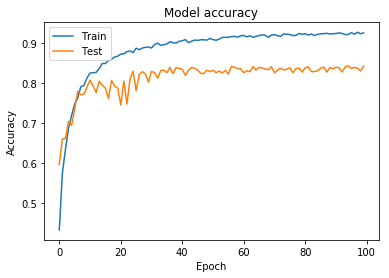

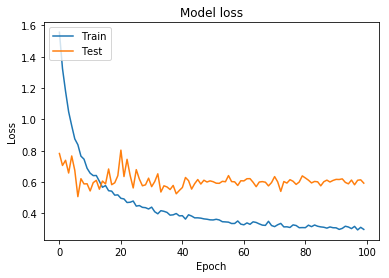

In [23]:
# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
y_pred = np.argmax(model.predict(med_vectors.query(x_test)), axis=1)
class_labels = [int_to_intent(y) for y in set(y_test)] 
report = classification_report(y_test, y_pred, target_names=class_labels)
print(class_labels)
print(confusion_matrix(y_test, y_pred))
print(report)

['Cardiovascular', 'Other']
[[1095  582]
 [1138 8125]]
                precision    recall  f1-score   support

Cardiovascular       0.49      0.65      0.56      1677
         Other       0.93      0.88      0.90      9263

   avg / total       0.87      0.84      0.85     10940



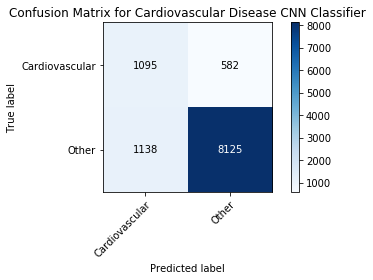

In [25]:
plot_confusion_matrix(y_test, y_pred, classes=class_labels
                      , title='Confusion Matrix for Cardiovascular Disease CNN Classifier')